### Deliverable 1: Preprocessing the Data for a Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q -U keras-tuner

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# Import the dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import keras_tuner as kt
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

#  Import and read the charity_data.csv.
application_df = pd.read_csv("https://raw.githubusercontent.com/Daniel-Sanudo/Neural_Network_Charity_Analysis/main/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN'])
application_df

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...
34294,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
name_freq = pd.DataFrame(
{
    'NAME':application_df['NAME'].value_counts().index.tolist(),
    'COUNT':list(application_df['NAME'].value_counts())
})
name_freq

,NAME,COUNT
0,PARENT BOOSTER USA INC,1260
1,TOPS CLUB INC,765
2,UNITED STATES BOWLING CONGRESS INC,700
3,WASHINGTON STATE UNIVERSITY,492
4,AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,408
...,...,...
19563,ST LOUIS SLAM WOMENS FOOTBALL,1
19564,AIESEC ALUMNI IBEROAMERICA CORP,1
19565,WEALLBLEEDRED ORG INC,1
19566,AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP &...,1


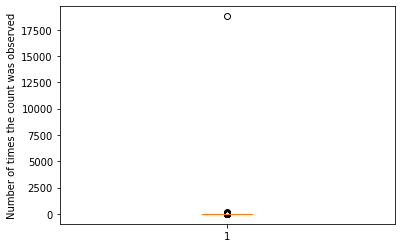

Lower bound = -3.875
Upper bound = 9.125


In [6]:
# Create boxplot to measure how many times the count is seen
repeated_requesters = name_freq['COUNT'].value_counts()
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Number of times the count was observed')
ax1.boxplot(repeated_requesters)
plt.show()

# Calculate the quartiles to determine the IQR for repeated requesters
quartiles = np.quantile(repeated_requesters,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

# Print Upper and lower Bounds
print(f'Lower bound = {lower_bound}')
print(f'Upper bound = {upper_bound}')

In [7]:
name_freq.loc[name_freq['COUNT']>upper_bound]

,NAME,COUNT
0,PARENT BOOSTER USA INC,1260
1,TOPS CLUB INC,765
2,UNITED STATES BOWLING CONGRESS INC,700
3,WASHINGTON STATE UNIVERSITY,492
4,AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,408
...,...,...
217,NATIONAL ASSOCIATION OF LETTER CARRIERS,10
218,AMERICAN FEDERATION OF LABOR AND CONGRESS OF I...,10
219,NATIONAL ASSOCIATION OF HISPANIC NURSES,10
220,SNOHOMISH HIGH SCHOOL PANTHER PARENTS CLUB,10


In [8]:
# Replace in dataframe
for name_entry in list(name_freq.loc[name_freq['COUNT']<=upper_bound]['NAME']):
    application_df['NAME'] = application_df['NAME'].replace(name_entry,"Other")

# Check to make sure binning was successful
application_df['NAME'].value_counts()

Other                                      21022
PARENT BOOSTER USA INC                      1260
TOPS CLUB INC                                765
UNITED STATES BOWLING CONGRESS INC           700
WASHINGTON STATE UNIVERSITY                  492
                                           ...  
CASCADE 4-H FOUNDATION                        10
FREE & ACCEPTED MASONS OF WASHINGTON          10
NEW MEXICO GARDEN CLUBS INC                   10
NATIONAL ASSOCIATION OF HISPANIC NURSES       10
UNION OF CALIFORNIA STATE WORKERS             10
Name: NAME, Length: 223, dtype: int64

In [9]:
# Look at INCOME_AMT value counts for binning
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [10]:
# Determine which values to replace if income is less than 100,000
replace_income=[
    '100000-499999',
    '1M-5M',
    '5M-10M',
    '10M-50M',
    '50M+'
]

# Replace in dataframe
for income in replace_income:
    application_df.INCOME_AMT = application_df.INCOME_AMT.replace(income,">100,000")
    
# Check to make sure binning was successful
application_df.INCOME_AMT.value_counts()

0              24388
>100,000        4893
25000-99999     3747
1-9999           728
10000-24999      543
Name: INCOME_AMT, dtype: int64

In [11]:
application_df.SPECIAL_CONSIDERATIONS = application_df.loc[(application_df.SPECIAL_CONSIDERATIONS == 'N'),'SPECIAL_CONSIDERATIONS'] = 0
application_df.SPECIAL_CONSIDERATIONS = application_df.loc[(application_df.SPECIAL_CONSIDERATIONS == 'Y'),'SPECIAL_CONSIDERATIONS'] = 1
application_df.SPECIAL_CONSIDERATIONS

0        1
1        1
2        1
3        1
4        1
        ..
34294    1
34295    1
34296    1
34297    1
34298    1
Name: SPECIAL_CONSIDERATIONS, Length: 34299, dtype: int64

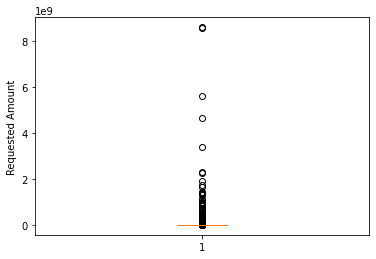

In [12]:
# Create boxplot with requested amount

req_amt = list(application_df.ASK_AMT)

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Requested Amount')
ax1.boxplot(req_amt)
plt.show()

In [13]:
 # Determine which data points are outside of the 1.5*IQR range
quartiles = np.quantile(req_amt,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

print(f'Lower bound = {lower_bound}')
print(f'Upper bound = {upper_bound}')
print(f'Minimum request = {min(req_amt)}')
print(f'Maximum request = {max(req_amt)}')
print(f'Number of requests above the upper bound = {len(application_df.loc[(application_df.ASK_AMT > upper_bound) | (application_df.ASK_AMT < lower_bound)])}')
print(f'Number of requests within the bounds = {len(application_df) - len(application_df.loc[(application_df.ASK_AMT > upper_bound) | (application_df.ASK_AMT < lower_bound)])}')
application_df.ASK_AMT.value_counts()

Lower bound = 887.0
Upper bound = 11855.0
Minimum request = 5000
Maximum request = 8597806340
Number of requests above the upper bound = 8206
Number of requests within the bounds = 26093


5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [14]:
# Look at APPLICATION_TYPE value counts for binning
application_df['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

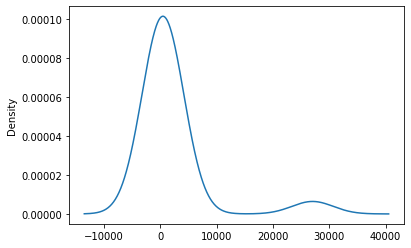

In [15]:
# Visualize the value counts of APPLICATION_TYPE
application_df['APPLICATION_TYPE'].value_counts().plot.density()

In [16]:
# Determine which values to replace if counts are less than ...?
replace_application=list(application_df['APPLICATION_TYPE'].value_counts()[application_df['APPLICATION_TYPE'].value_counts()<700].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
Other      804
T8         737
T7         725
Name: APPLICATION_TYPE, dtype: int64

In [17]:
# Look at CLASSIFICATION value counts for binning
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

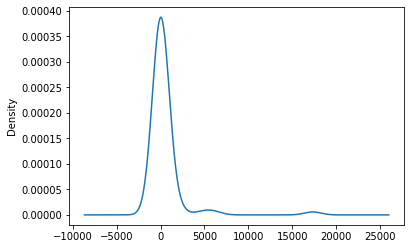

In [18]:
# Visualize the value counts of CLASSIFICATION
application_df.CLASSIFICATION.value_counts().plot.density()

In [19]:
# Determine which values to replace if counts are less than ..?
replace_class = list(application_df.CLASSIFICATION.value_counts()[application_df.CLASSIFICATION.value_counts() < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [20]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == 'object'].index.tolist()
application_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [21]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_25000-99999,"INCOME_AMT_>100,000"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True,right_index=True)
application_df = application_df.drop(application_cat,axis=1)
application_df.head()

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_25000-99999,"INCOME_AMT_>100,000"
0,1,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# Split our preprocessed data into our features and target arrays
y = application_df.IS_SUCCESSFUL.values
X = application_df.drop(columns='IS_SUCCESSFUL').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18)

In [24]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [25]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=len(X_train[0])), activation=activation, input_dim=len(X_train[0])))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=len(X_train[0])),activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [26]:
# Import the kerastuner library
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [27]:
# Define the checkpoint path and filenames
os.makedirs("optimizer_checkpoints/",exist_ok=True)

# Create a callback class that saves the model's weights every N epochs
# https://stackoverflow.com/questions/51186330/save-model-weights-at-the-end-of-every-n-epochs
class WeightsSaver(Callback):
    _count = 0
    def __init__(self, N):
        self.N = N
        self.epoch = 1
        WeightsSaver._count += 1
    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.N == 0:
            os.makedirs(f'optimizer_checkpoints/Trial_Model_{WeightsSaver._count}/',exist_ok=True)
            name = f'optimizer_checkpoints/Trial_Model_{WeightsSaver._count}/weights_epoch_{self.epoch}.h5'
            self.model.save_weights(name)
        self.epoch += 1

In [28]:
 # Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test),callbacks=[WeightsSaver(5)])

Trial 60 Complete [00h 01m 23s]
val_accuracy: 0.7778425812721252

Best val_accuracy So Far: 0.7793586254119873
Total elapsed time: 00h 28m 11s


In [29]:
# Get top three model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 99, 'num_layers': 3, 'units_0': 45, 'units_1': 135, 'units_2': 206, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 37, 'num_layers': 2, 'units_0': 51, 'units_1': 58, 'units_2': 183, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
{'activation': 'relu', 'first_units': 76, 'num_layers': 3, 'units_0': 154, 'units_1': 175, 'units_2': 21, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}


In [30]:
# Evaluate the top three models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.4513 - accuracy: 0.7794 - 593ms/epoch - 2ms/step
Loss: 0.45133736729621887, Accuracy: 0.7793586254119873
268/268 - 1s - loss: 0.4538 - accuracy: 0.7791 - 579ms/epoch - 2ms/step
Loss: 0.4537951648235321, Accuracy: 0.7791253924369812
268/268 - 1s - loss: 0.4544 - accuracy: 0.7790 - 592ms/epoch - 2ms/step
Loss: 0.45436549186706543, Accuracy: 0.7790087461471558


In [31]:
best_model = top_model[0]
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 99)                25839     
                                                                 
 dense_1 (Dense)             (None, 45)                4500      
                                                                 
 dense_2 (Dense)             (None, 135)               6210      
                                                                 
 dense_3 (Dense)             (None, 206)               28016     
                                                                 
 dense_4 (Dense)             (None, 1)                 207       
                                                                 
Total params: 64,772
Trainable params: 64,772
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
first_unit = 99
hidden_nodes_layer1 = 45
hidden_nodes_layer2 = 135
hidden_nodes_layer3 = 206

nn = tf.keras.models.Sequential()

# First layer
nn.add(tf.keras.layers.Dense(units=first_unit, input_dim=number_input_features, activation="tanh"))

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="tanh"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 99)                25839     
                                                                 
 dense_6 (Dense)             (None, 45)                4500      
                                                                 
 dense_7 (Dense)             (None, 135)               6210      
                                                                 
 dense_8 (Dense)             (None, 206)               28016     
                                                                 
 dense_9 (Dense)             (None, 1)                 207       
                                                                 
Total params: 64,772
Trainable params: 64,772
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
# Train the model and save weights every 5 epochs
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[WeightsSaver(5)])

Epoch 1/50
804/804 [==============================] - 4s 4ms/step - loss: 0.4808 - accuracy: 0.7652
Epoch 2/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4527 - accuracy: 0.7808
Epoch 3/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4491 - accuracy: 0.7814
Epoch 4/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4461 - accuracy: 0.7812
Epoch 5/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4451 - accuracy: 0.7823
Epoch 6/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4436 - accuracy: 0.7829
Epoch 7/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4418 - accuracy: 0.7826
Epoch 8/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4418 - accuracy: 0.7846
Epoch 9/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4390 - accuracy: 0.7844
Epoch 10/50
804/804 [==============================] - 2s 3ms/step - loss: 0.4395 - accuracy: 0.7840

In [35]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.4633 - accuracy: 0.7753 - 541ms/epoch - 2ms/step
Loss: 0.46327778697013855, Accuracy: 0.7752769589424133
